# Divoce

In [ ]:
#!pip install jieba
#!pip install "gensim==4.3.3" "spacy==3.7.2" "thinc==8.2.2"

   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
    --------------------------------------- 0.3/12.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.1 MB 1.3 MB/s eta 0:00:09
   --- ------------------------------------ 1.0/12.1 MB 1.9 MB/s eta 0:00:06
   ----- ---------------------------------- 1.6/12.1 MB 2.2 MB/s eta 0:00:05
   ------ --------------------------------- 2.1/12.1 MB 2.2 MB/s eta 0:00:05
   -------- ------------------------------- 2.6/12.1 MB 2.3 MB/s eta 0:00:05
   --------- ------------------------------ 2.9/12.1 MB 2.3 MB/s eta 0:00:04
   ------------ --------------------------- 3.7/12.1 MB 2.3 MB/s eta 0:00:04
   ------------- -------------------------- 3.9/12.1 MB 2.3 MB/s eta 0:00:04
   -------------- ------------------------- 4.5/12.1 MB 2.3 MB/s eta 0:00:04
   ---------------- ----------------------- 5.0/12.1 MB 2.2 MB/s eta 0:00:04
   ----------------- ---------------------- 5.2/12.1 MB 2.2 MB/s eta 0:00:04
   ----------

In [ ]:
#!pip install plotly


   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.8 MB ? eta -:--:--
    --------------------------------------- 0.3/14.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/14.8 MB 1.2 MB/s eta 0:00:12
   -- ------------------------------------- 0.8/14.8 MB 1.3 MB/s eta 0:00:11
   --- ------------------------------------ 1.3/14.8 MB 1.4 MB/s eta 0:00:10
   ---- ----------------------------------- 1.6/14.8 MB 1.4 MB/s eta 0:00:10
   ------ --------------------------------- 2.4/14.8 MB 1.7 MB/s eta 0:00:08
   ------- -------------------------------- 2.9/14.8 MB 1.8 MB/s eta 0:00:07
   -------- ------------------------------- 3.1/14.8 MB 1.8 MB/s eta 0:00:07
   --------- ------------------------------ 3.7/14.8 MB 1.8 MB/s eta 0:00:07
   ---------- ----------------------------- 3.9/14.8 MB 1.8 MB/s eta 0:00:06
   ------------ --------------------------- 4.5/14.8 MB 1.9 MB/s eta 0:00:06
   ------------- ---

In [1]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch

from matplotlib.font_manager import fontManager
import plotly.express as px

sns.set_style("darkgrid")

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary('/Users/rolya/Desktop/DIV/divoce_project2/dict/dict.txt.big')
jieba.load_userdict('/Users/rolya/Desktop/DIV/divoce_project2/dict/user_dict.txt')

# 新增stopwords
with open('/Users/rolya/Desktop/DIV/divoce_project2/dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from c:\Users\rolya\Desktop\DIV\divoce_project2\dict\dict.txt.big ...
Dumping model to file cache C:\Users\rolya\AppData\Local\Temp\jieba.u2ecd0c6dc6535871c5cc6cd50f65ab67.cache
Loading model cost 1.600 seconds.
Prefix dict has been built successfully.


In [4]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [5]:
# 讀入中文示範資料集
origin_data = pd.read_csv('/Users/rolya/Desktop/DIV/divoce_project2/text.csv')

In [6]:
# 資料前處理

# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData.head(10)

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
1,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,偷看手機是不對的,"[偷看, 手機]"
2,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,但如果已經結婚了,[結婚]
3,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,太太想看你手機,"[太太, 手機]"
4,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,真的可以拒絕嗎,"[真的, 拒絕]"
5,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,感覺你拒絕,"[感覺, 拒絕]"
6,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,就是心裡有鬼,[有鬼]
7,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,只是讓太太猜忌,"[太太, 猜忌]"
8,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,自己日子難過,"[日子, 難過]"
10,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,我手機都是隨便太太看,"[手機, 隨便, 太太]"
11,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,但每次都被看的提心吊膽,"[每次, 提心吊膽]"


In [7]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word,word_list_bigrams
1,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,偷看手機是不對的,"[偷看, 手機]","[偷看, 手機]"
2,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,但如果已經結婚了,[結婚],[結婚]
3,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,太太想看你手機,"[太太, 手機]","[太太, 手機]"
4,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,真的可以拒絕嗎,"[真的, 拒絕]","[真的, 拒絕]"
5,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,感覺你拒絕,"[感覺, 拒絕]","[感覺, 拒絕]"


In [8]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [9]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 39393


['小孩', '離婚', '老婆', '老公', '真的', '孩子', '工作', '婚姻', '結婚', '太太']

In [10]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 95013
average length of sentences: 3.452327576226411


In [11]:
# 環境變數設定
%env PYTHONHASHSEED=2025

env: PYTHONHASHSEED=2025


In [12]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 8


In [13]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

In [14]:
# 檢查最相關的字
w2v_model.wv.most_similar('溝通',topn=10)

[('思考', 0.7755464315414429),
 ('解決', 0.7708988785743713),
 ('期待', 0.6676611304283142),
 ('嘗試', 0.6662196516990662),
 ('這是', 0.6276875734329224),
 ('衝突', 0.6261622309684753),
 ('表達', 0.6218885183334351),
 ('事件', 0.6023396253585815),
 ('想法', 0.5949125289916992),
 ('需求', 0.5907225012779236)]

In [15]:
w2v_model.wv.most_similar('外遇',topn=10)

[('提出', 0.8008367419242859),
 ('原因', 0.7528184652328491),
 ('不爽', 0.7414447665214539),
 ('分手', 0.7389088869094849),
 ('實在', 0.732452392578125),
 ('念頭', 0.7268778681755066),
 ('出軌', 0.7090317606925964),
 ('乾脆', 0.700692892074585),
 ('平靜', 0.693835437297821),
 ('理由', 0.6839743852615356)]

In [16]:
w2v_model.wv.most_similar(['溝通','外遇'],topn=10)

[('平靜', 0.7731956839561462),
 ('解決', 0.7368565797805786),
 ('思考', 0.7182171940803528),
 ('值得', 0.715507447719574),
 ('理由', 0.70955491065979),
 ('想法', 0.6994882225990295),
 ('提出', 0.6934615969657898),
 ('尊重', 0.6934552788734436),
 ('道理', 0.6815539598464966),
 ('原因', 0.6742791533470154)]

In [17]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['外遇','離婚'],topn=10)

[('休息', 0.6033270359039307),
 ('白天', 0.5987855792045593),
 ('在家', 0.5936435461044312),
 ('大人', 0.5754421353340149),
 ('足夠', 0.5643977522850037),
 ('接送', 0.5636379718780518),
 ('下班', 0.5620827078819275),
 ('心力', 0.5549818277359009),
 ('育兒', 0.5517842173576355),
 ('旁邊', 0.5506572723388672)]

In [18]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("財產","家庭")

-0.18695961

In [19]:
w2v_model.wv.similarity("孩子","照顧")

0.55098337

In [20]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["孩子", "照顧", '財產'])

'財產'

In [21]:
# 相對關係
w2v_model.wv.most_similar(positive=["孩子"], negative=["照顧"], topn=5)

[('痛苦', 0.5897860527038574),
 ('故事', 0.5843417048454285),
 ('紀錄', 0.5227385759353638),
 ('妻子', 0.5202898979187012),
 ('個性', 0.5193036198616028)]

In [22]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

In [23]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat

In [24]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)

In [25]:
getVecs(w2v_model,['溝通','外遇'])

array([[ 0.05552926,  0.03847976, -0.23192777,  0.06041394, -0.03632559,
        -0.04825368, -0.09273008,  0.06537188,  0.07540878,  0.11345442,
         0.10255916, -0.077728  ,  0.03348193, -0.02929123,  0.04965089,
         0.04994745, -0.02007875,  0.06827826, -0.00043407, -0.01652355,
         0.07447162,  0.06956953,  0.04445267, -0.06862568, -0.01181999,
        -0.03680974, -0.09098391, -0.02162968,  0.0925396 , -0.03726147,
         0.03511068, -0.0015918 , -0.04098483, -0.08775292,  0.02748766,
        -0.0189511 ,  0.09938143, -0.00548935, -0.16770932,  0.03284688,
         0.05587117, -0.09926225, -0.09662215,  0.02078925, -0.0978763 ,
        -0.10456892, -0.08619943, -0.07782117, -0.00280136, -0.02179379,
         0.10193834,  0.0503955 , -0.00199134,  0.06327718,  0.05917658,
        -0.00107532, -0.03456983, -0.12342957,  0.02685144, -0.00024162,
        -0.08171521,  0.02174407,  0.03526353, -0.0224024 ,  0.01412679,
        -0.03493559, -0.07929365, -0.11893469, -0.0

In [26]:
# 擴展相似的字詞
def expandPosWord(model, words:list, top_n:int, split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])

    return list(set(expand))

In [27]:
expandPosWord(w2v_model,['溝通','外遇'],top_n = 10)

['期待',
 '解決',
 '提出',
 '實在',
 '表達',
 '想法',
 '乾脆',
 '需求',
 '事件',
 '原因',
 '嘗試',
 '思考',
 '分手',
 '理由',
 '出軌',
 '衝突',
 '不爽',
 '這是',
 '平靜',
 '念頭']

以上字詞是依照第二次專案tf-idf前十大字詞
4828	工作
3219	問題
9604	美國
4481	家庭
10732	財產
7951	溝通
3646	外遇
6672	改變
8172	照顧
1882	公公

In [34]:
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('/Users/rolya/Desktop/DIV/divoce_project2/TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()

# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [35]:
sample_words = np.random.choice(list(words),150,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(150, 128)
(150, 2)


In [36]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

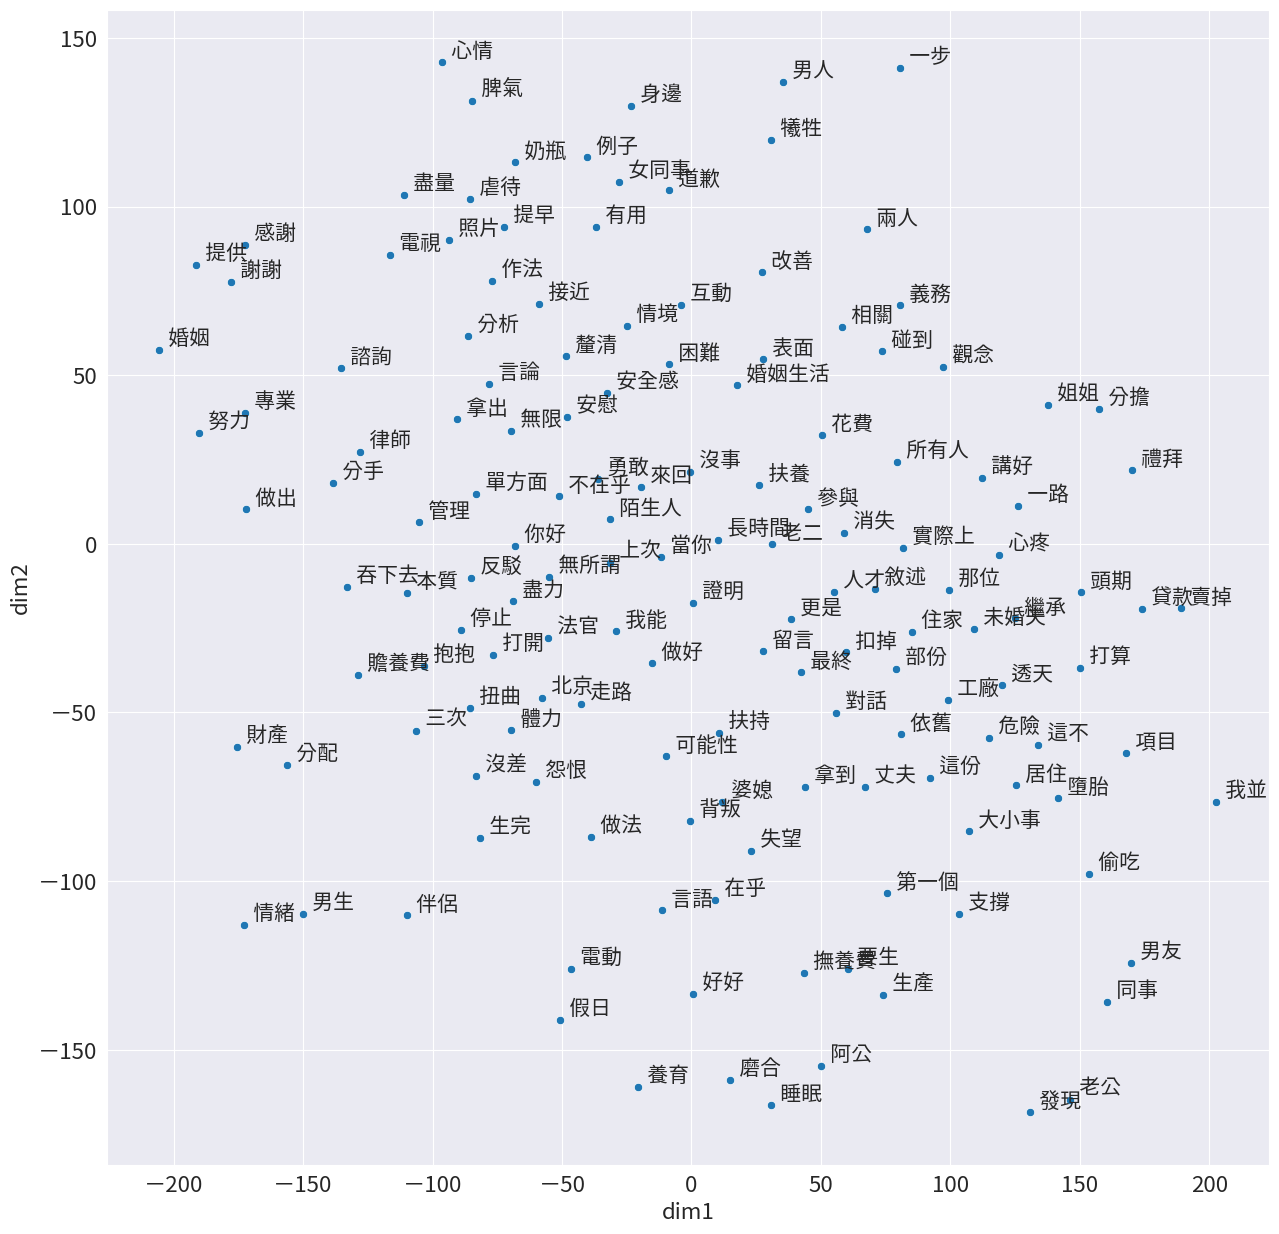

In [37]:
plotScatter(word_df)

In [39]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(150, 3)


3D圖能縮放

將字分群


In [ ]:
#!pip install scikit-learn-extra

In [41]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result

In [42]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

### Transformers Embeddings

#### 使用 Sentence-Transformer 套件   
參考資料：https://www.sbert.net/index.html

In [ ]:
#!pip install -U sentence-transformers

   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.4 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.4 MB 2.6 MB/s eta 0:00:04
   ------ --------------------------------- 1.6/10.4 MB 3.0 MB/s eta 0:00:03
   ------- -------------------------------- 1.8/10.4 MB 2.5 MB/s eta 0:00:04
   ---------- ----------------------------- 2.6/10.4 MB 2.7 MB/s eta 0:00:03
   ------------ --------------------------- 3.1/10.4 MB 2.8 MB/s eta 0:00:03
   --------------- ------------------------ 3.9/10.4 MB 2.9 MB/s eta 0:00:03
   ------------------ --------------------- 4.7/10.4 MB 2.9 MB/s eta 0:00:02
   -------------------- ------------------- 5.2/10.4 MB 3.0 MB/s eta 0:00:02
   ------------------------ --------------- 6.3/10.4 MB 3.1 MB/s eta 0:00:02
   --------------------------- ------------ 7.1/10.4 MB 3.2 MB/s eta 0:00:02
   ----------------------------- ---------- 7.6/10.4 MB 3.2 MB/s eta 0:00:01
   ----------

In [50]:
from sentence_transformers import SentenceTransformer, models, util

#### 小模型，以BERT為範例

中文 bert-base-chinese

In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

In [53]:
# 示範句子
sentences = [
    "今天天氣很好。",
    "今天是個晴空萬里的好天氣。",
    "我晚上想去公園散步。"
]

# 使用 encode() 對資料做embedding
embeddings_ch = bert_ch.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_ch, embeddings_ch)

# 印出句子間的cosine similarity分數
result = []
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
result_df.sort_values("score", ascending = False)

,sentence1,sentence2,score
0,今天天氣很好。,今天是個晴空萬里的好天氣。,0.914067
1,今天天氣很好。,我晚上想去公園散步。,0.787589
2,今天是個晴空萬里的好天氣。,我晚上想去公園散步。,0.759642


### 使用embedding做NLP任務

#### 相似文件

In [58]:
df_similar = origin_data[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar.head(5)

C:\Users\rolya\AppData\Local\Temp\ipykernel_13724\852741673.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,system_id,artTitle,artContent
0,1,[求助]真的可以不給看手機嗎？,常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒絕嗎感覺你拒絕就是心裡有...
1,2,Re:老公工作不穩定,因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到這世間只是苦難...
2,3,Re:[求助]真的可以不給看手機嗎？,手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎三隻四隻不夠可以辦五隻十...
3,4,[心情]我搞不懂老公到底在想甚麼,其實都是小事但都可以吵到離婚可能我們就是幾歲的小孩昨晚上床睡覺後一直覺得很冷老公也喊冷想說睡...
4,5,Re:[心情]我搞不懂老公到底在想甚麼,把棉被翻好正面嗯嗯有嗯那你幹嘛抱怨你老公不是誰上床睡覺還會檢查棉被正反的嗎我我也覺得你半夜叫...


使用 bert-base-chinese 做示範

取得整個文集的 embeddings

In [60]:
corpus_embeddings = bert_ch.encode(
    df_similar['artContent'],
    convert_to_tensor=True,
    batch_size=32
)

In [61]:
query_num = 6 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: Re:[閒聊]離婚的掙扎

 資料集中前五相似的文章:
Re:[閒聊]離婚的掙扎 (Score: 1.0000)
Re:兩人的溝通與目前的情況 (Score: 0.9643)
Re:[心情]人生再重來一次，我不會生小孩 (Score: 0.9635)
Re:[求助]先生的女助理 (Score: 0.9628)
Re:[心情]老公喝酒不懂克制 (Score: 0.9627)






In [62]:
query_num = 30

top_k = 5

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [閒聊]美女朋友婚後一直找人約砲

 資料集中前五相似的文章:
[閒聊]美女朋友婚後一直找人約砲 (Score: 1.0000)
該繼續挽回，還是該放手了？ (Score: 0.9864)
[求助]精神出軌後成功修復感情經驗? (Score: 0.9856)
[閒聊]人妻外食被搞懷孕後，繼續外食？ (Score: 0.9849)
Re:[閒聊]老公有異性友人 (Score: 0.9847)






### 分類任務
使用bert-base-chinese模型對ppt文集做embeddings，接著訓練分類器。（參考week7程式碼）

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [64]:
from sentence_transformers import SentenceTransformer, models, util

- 版別：婚姻版 結婚版 八卦版
- 工作流程平台搜尋/排除關鍵字：

文章數分別為<br>
Gossiping    3380<br>
GetMarry     2531<br>
marriage     2204

In [71]:
import pandas as pd

# 讀取三個 CSV 檔案
df1 = pd.read_csv('/Users/rolya/Desktop/DIV/divoce_project2/text.csv')
df2 = pd.read_csv('/Users/rolya/Desktop/DIV/divoce_project2/GetMarry.csv')
df3 = pd.read_csv('/Users/rolya/Desktop/DIV/divoce_project2/Gossiping.csv')

# 合併成一個 DataFrame
merged_df = pd.concat([df1, df2, df3], ignore_index=True)

# 儲存為新的 merge.csv
merged_df.to_csv('merge.csv', index=False)


In [ ]:
div = pd.read_csv("merge.csv")
div.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,safelove,marriage,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""FlyOncidium""...",114.137.169.105,2021-01-10 01:20:56,ptt
1,2,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,Re:老公工作不穩定,2021-01-09 11:25:34,mayko,marriage,"因為男方工作不穩定,房東才不肯租,只好換女生承租,對吧\n很殘忍的說...這無緣的孩子聰明,...",[],36.229.84.229,2021-01-10 01:20:56,ptt
2,3,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,Re:[求助]真的可以不給看手機嗎？,2021-01-09 19:05:00,loser1,marriage,手機要看就給看啊！\n先帝爺不是說，\n一隻不夠，不能辦兩隻嗎？\n兩隻不夠，不能辦三隻嗎？...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""mark0204"", ""...",118.170.238.138,2021-01-10 01:20:56,ptt


## 資料清理
利用標點符號斷句

文集的標題和內容納入分析的內容，成為content欄位

In [ ]:
# 過濾 nan 的資料
div = div.dropna(subset=['artTitle'])
div = div.dropna(subset=['artContent'])
# 移除網址格式
div["artContent"] = div.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
div["artTitle"] = div["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
div["artContent"] = div.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
div["artTitle"] = div["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
div["content"] = div["artTitle"] + div["artContent"]
div = div[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
div.head()

,content,artUrl,artCatagory
0,求助真的可以不給看手機嗎常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒...,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,marriage
1,老公工作不穩定因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到...,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,marriage
2,求助真的可以不給看手機嗎手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎...,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,marriage
3,心情我搞不懂老公到底在想甚麼其實都是小事但都可以吵到離婚可能我們就是幾歲的小孩昨晚上床睡覺後...,https://www.ptt.cc/bbs/marriage/M.1610193770.A...,marriage
4,心情我搞不懂老公到底在想甚麼把棉被翻好正面嗯嗯有嗯那你幹嘛抱怨你老公不是誰上床睡覺還會檢查棉...,https://www.ptt.cc/bbs/marriage/M.1610203445.A...,marriage


### 使用Bert做encoding

In [ ]:
div["embeddings"] = div.content.apply(lambda x: bert_ch.encode(x))
div.head(3)

,content,artUrl,artCatagory,embeddings
0,求助真的可以不給看手機嗎常常看大家說偷看手機是不對的但如果已經結婚了太太想看你手機真的可以拒...,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,marriage,"[0.8504211, -0.23771943, -0.14535092, 0.156168..."
1,老公工作不穩定因為男方工作不穩定房東才不肯租只好換女生承租對吧很殘忍的說這無緣的孩子聰明來到...,https://www.ptt.cc/bbs/marriage/M.1610162736.A...,marriage,"[0.7396465, -0.14757201, -0.057030175, 0.26861..."
2,求助真的可以不給看手機嗎手機要看就給看啊先帝爺不是說一隻不夠不能辦兩隻嗎兩隻不夠不能辦三隻嗎...,https://www.ptt.cc/bbs/marriage/M.1610190309.A...,marriage,"[0.4144313, -0.095341206, -0.2705029, 0.380942..."


In [75]:
import numpy as np
from ast import literal_eval

In [ ]:
data = div.copy()

X = data["embeddings"].apply(pd.Series)
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

           0         1         2         3         4         5         6    \
5325  0.578834 -0.050640 -0.503452  0.114320  0.008045  0.006949 -0.056759   
6304  0.393490  0.062839 -0.422073  0.157619  0.078032 -0.188103  0.018693   
1659  0.629233 -0.231260 -0.266918  0.320200 -0.087541 -0.173598 -0.265297   
1280  0.670054 -0.171460 -0.248393  0.444933 -0.170084 -0.130054 -0.090347   
291   0.621767 -0.093077 -0.131523  0.232634 -0.262020 -0.321169 -0.187148   

           7         8         9    ...       758       759       760  \
5325  0.107957 -0.071790 -0.321657  ... -0.201785 -0.409468  0.127512   
6304  0.168009 -0.057865 -0.318298  ... -0.059410 -0.456915  0.209086   
1659  0.012857 -0.264234 -0.477913  ...  0.013435 -0.425337  0.112885   
1280 -0.076344 -0.472568 -0.343588  ... -0.273166 -0.459275  0.273230   
291  -0.086306 -0.223639 -0.403096  ... -0.066033 -0.425651  0.224642   

           761       762       763       764       765       766       767  
5325  0.211407 

In [77]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf

c:\Users\rolya\anaconda3\envs\Syllabus\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [78]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
print(y_pred[:10])

['Gossiping' 'Gossiping' 'Gossiping' 'marriage' 'GetMarry' 'marriage'
 'marriage' 'GetMarry' 'marriage' 'Gossiping']


In [79]:
from sklearn.metrics import classification_report

In [80]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    GetMarry       1.00      1.00      1.00       768
   Gossiping       0.99      0.99      0.99      1011
    marriage       0.99      0.99      0.99       655

    accuracy                           0.99      2434
   macro avg       0.99      0.99      0.99      2434
weighted avg       0.99      0.99      0.99      2434



##  用訓練好的分類器來預測不同時間的文章類別

In [100]:
file_list = ["GetMarry_t.csv", "Gossiping_t.csv", "marriage_t.csv"]
dfs = [pd.read_csv(f) for f in file_list]
ct = pd.concat(dfs, ignore_index=True)
ct.dropna(inplace=True)
ct

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/GetMarry/M.1653965335.A...,[推薦]彰化_DeerHer客製手工喜餅,2022-05-31 10:48:52,pieme,GetMarry,廠商所在地區:彰化\n\n是什麼場合用到:訂結婚_111/5\n\n廠商名稱:\n喜餅:\n...,[],36.232.149.35,2022-06-01 01:14:50,ptt
1,2,https://www.ptt.cc/bbs/GetMarry/M.1653974818.A...,[分享]台北/荳蔻攝影工作室婚紗照,2022-05-31 13:26:56,ajjhhj,GetMarry,剛開始查婚紗資訊，真的好討厭傳統婚紗店的組數限制，或是各種無止境加購方案，也好\n怕遇到纏人...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""exorcist1"", ...",223.141.4.215,2022-06-01 01:14:50,ptt
2,3,https://www.ptt.cc/bbs/GetMarry/M.1654041655.A...,[請益]Oohlalove喜餅品項選擇,2022-06-01 08:00:53,love07erika,GetMarry,選擇障礙的新娘來求助了！\n\nC區的選擇掙扎到要給品項的deadline…\n目前確定抹茶...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""mimiwei955"",...",111.82.79.25,2022-06-02 01:14:43,ptt
3,4,https://www.ptt.cc/bbs/GetMarry/M.1654042316.A...,[贈送]白色及粉色小禮服,2022-06-01 08:11:54,cherishposse,GetMarry,《洽中，暫勿來信》\n\n已結婚完幾年了才發現還有兩件小禮服擱置在家裡，因家人暫時也用不到了...,[],101.10.0.149,2022-06-02 01:14:43,ptt
4,5,https://www.ptt.cc/bbs/GetMarry/M.1654050290.A...,[廣宣]OohLaLove喜餅,2022-06-01 10:24:48,michael9586,GetMarry,新人or廠商所在地區:台中\n\n是屬於新人哪種場合:結婚 2022/12/18\n\n\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kenkao25"", ""...",223.138.172.86,2022-06-02 01:14:43,ptt
...,...,...,...,...,...,...,...,...,...,...,...
5222,1375,https://www.ptt.cc/bbs/marriage/M.1672325600.A...,Re:[心情]果然跟版上說的一樣，還是得離婚...,2022-12-29 22:53:18,aass5566,marriage,感謝這個決定？\n\n我是覺得根本是被這個諮商害到了吧？\n\n如果不是弄這個諮商\n\n早...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""wts4832"", ""c...",49.158.132.119,2022-12-30 01:57:14,ptt
5223,1376,https://www.ptt.cc/bbs/marriage/M.1672369383.A...,Re:[求助]老公偷拍女同事腿,2022-12-30 11:03:00,GunOfWind,marriage,先說結論 離婚吧\n沒有小孩 你不能接受 就離婚 +1 吧\n程度問題\n就像有些人會...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""robertdelun""...",125.227.145.31,2022-12-31 01:52:50,ptt
5224,1377,https://www.ptt.cc/bbs/marriage/M.1672444694.A...,Re:[閒聊]另一半的家庭觀念,2022-12-31 07:58:12,magicbook123,marriage,首先，有問題不要上來發文\n\n這裡是離婚板 不會給什麼好建議 開口先喊離婚\n\n就算有正...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""mtyc"", ""cmtC...",223.137.86.71,2023-01-01 01:51:58,ptt
5225,1378,https://www.ptt.cc/bbs/marriage/M.1672455232.A...,Re:[閒聊]另一半的家庭觀念,2022-12-31 10:53:50,lamabclamabc,marriage,原PO我有看你舊文，也有留意你的補充和回文裏的推文，看得出來你真的很困擾。\n\n很高興你決...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""lastever"", ""...",155.137.208.19,2023-01-01 01:51:58,ptt


In [101]:
# 過濾 nan 的資料
ct = ct.dropna(subset=['artTitle'])
ct = ct.dropna(subset=['artContent'])
# 移除網址格式
ct["artContent"] = ct.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
ct["artTitle"] = ct["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
ct["artContent"] = ct.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ct["artTitle"] = ct["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
ct.head()


,content,artUrl,artCatagory
0,推薦彰化客製手工喜餅廠商所在地區彰化是什麼場合用到訂結婚廠商名稱喜餅手工喜餅聯絡資訊官網訂購...,https://www.ptt.cc/bbs/GetMarry/M.1653965335.A...,GetMarry
1,分享台北荳蔻攝影工作室婚紗照剛開始查婚紗資訊真的好討厭傳統婚紗店的組數限制或是各種無止境加購...,https://www.ptt.cc/bbs/GetMarry/M.1653974818.A...,GetMarry
2,請益喜餅品項選擇選擇障礙的新娘來求助了區的選擇掙扎到要給品項的目前確定抹茶鹽之花另一個想要檸...,https://www.ptt.cc/bbs/GetMarry/M.1654041655.A...,GetMarry
3,贈送白色及粉色小禮服洽中暫勿來信已結婚完幾年了才發現還有兩件小禮服擱置在家裡因家人暫時也用不...,https://www.ptt.cc/bbs/GetMarry/M.1654042316.A...,GetMarry
4,廣宣喜餅新人廠商所在地區台中是屬於新人哪種場合結婚以上三項依照要推薦的廠商類別而填寫不得不填...,https://www.ptt.cc/bbs/GetMarry/M.1654050290.A...,GetMarry


In [102]:
ct['artCatagory'].value_counts()

artCatagory
GetMarry     2301
Gossiping    1508
marriage     1347
Name: count, dtype: int64

In [103]:
ct["embeddings"] = ct.content.apply(lambda x: bert_ch.encode(x))
ct.head(3)

,content,artUrl,artCatagory,embeddings
0,推薦彰化客製手工喜餅廠商所在地區彰化是什麼場合用到訂結婚廠商名稱喜餅手工喜餅聯絡資訊官網訂購...,https://www.ptt.cc/bbs/GetMarry/M.1653965335.A...,GetMarry,"[0.5550073, -0.20386253, -0.3193656, 0.1848941..."
1,分享台北荳蔻攝影工作室婚紗照剛開始查婚紗資訊真的好討厭傳統婚紗店的組數限制或是各種無止境加購...,https://www.ptt.cc/bbs/GetMarry/M.1653974818.A...,GetMarry,"[0.50719243, -0.0016513392, -0.3523839, 0.2919..."
2,請益喜餅品項選擇選擇障礙的新娘來求助了區的選擇掙扎到要給品項的目前確定抹茶鹽之花另一個想要檸...,https://www.ptt.cc/bbs/GetMarry/M.1654041655.A...,GetMarry,"[0.5617253, -0.14796321, -0.42836052, 0.094054..."


In [104]:
X = ct["embeddings"].apply(pd.Series)
y = ct['artCatagory']

y_pred = clf.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

    GetMarry       1.00      0.99      1.00      2301
   Gossiping       0.99      0.97      0.98      1508
    marriage       0.97      0.99      0.98      1347

    accuracy                           0.99      5156
   macro avg       0.99      0.99      0.99      5156
weighted avg       0.99      0.99      0.99      5156



In [109]:
false_pred = ct.query("artCatagory != pred").loc[:,['artCatagory',"pred"]]
false_pred

,artCatagory,pred
82,GetMarry,marriage
968,GetMarry,Gossiping
975,GetMarry,marriage
1103,GetMarry,Gossiping
1108,GetMarry,Gossiping
1168,GetMarry,marriage
1396,GetMarry,Gossiping
1789,GetMarry,Gossiping
1948,GetMarry,marriage
2046,GetMarry,Gossiping


In [110]:
false_pred.loc[false_pred['artCatagory']=='Gossiping', :].head(20)

,artCatagory,pred
2381,Gossiping,marriage
2437,Gossiping,marriage
2454,Gossiping,marriage
2456,Gossiping,marriage
2465,Gossiping,GetMarry
2466,Gossiping,marriage
2474,Gossiping,marriage
2545,Gossiping,marriage
2607,Gossiping,marriage
2646,Gossiping,GetMarry


In [115]:
ct_wrong = ct[(ct["artCatagory"] == "Gossiping") & (ct["pred"] != "Gossiping")]
ct_wrong[["artCatagory", "pred", "content","embeddings"]].head(10)


,artCatagory,pred,content,embeddings
2381,Gossiping,marriage,問卦少子化女生的問題佔大部分吧台女白天要上班下班要養家假日要讀書沒辦法到外面聯誼之前我在臉書...,"[0.8725247, -0.08411743, -0.203732, 0.27536434..."
2437,Gossiping,marriage,新聞工程師尪被孕妻抓包上按摩店性交易簽工程師尪被孕妻抓包上按摩店性交易簽完協議再犯下場曝光年...,"[0.46804097, -0.016441723, -0.2565862, 0.06258..."
2454,Gossiping,marriage,問卦你各位買得起房就真的會結婚生小孩結婚可能但生小孩很難買不起房然後呢別忘了還有房貸再來是小...,"[0.65234625, -0.09828554, -0.12775144, 0.26947..."
2456,Gossiping,marriage,問卦台女找尋結婚對象有人留言說不生幹嘛結婚我只是能說太天真了婚姻是個強大道德武器之後至於要不...,"[0.79514945, -0.067468375, -0.14028932, 0.4278..."
2465,Gossiping,GetMarry,問卦台女找尋結婚對象小妹我的親辜徵友條件跟低卡上這位列的有相似但小妹的親辜身高體重而且比較年...,"[0.928948, -0.1616967, 0.04163605, 0.56533563,..."
2466,Gossiping,marriage,問卦家長是巨嬰嗎一般來說親子關係是要培養的不管是爸爸還是媽媽不是只負責生不負責養那以前都會說...,"[0.8342646, -0.11413084, -0.100559324, 0.21266..."
2474,Gossiping,marriage,新聞色人妻新婚不久就出軌誘惑男同事小色人妻新婚不久就出軌誘惑男同事小朋友才戴套把你榨乾記者柯...,"[0.58158386, 0.022150613, -0.3089661, 0.124260..."
2545,Gossiping,marriage,問卦老婆只想生一個建議你先跟你老婆借一下手機然後把你老婆的手機格式化再跟她講解備份的重要性有...,"[0.5313501, -0.26143715, -0.0760047, 0.5591018..."
2607,Gossiping,marriage,問卦男人不婚不生把錢花在出國也爽以前常有人說台女沒啥在存錢總是把錢花在出國玩樂享受美景美食上...,"[0.5529267, 0.08784643, -0.022090623, 0.515583..."
2646,Gossiping,GetMarry,問卦有萬為什麼不娶台灣要娶越南老婆對聽說去年有位造型師娶越南老婆但是價格驚人全部流程加上婚禮...,"[0.5280451, -0.01208675, 0.1979833, 0.43109772..."


## 第三次讀書會 BERT (Encoder-only-model)
---

**前處理常用套件**


In [ ]:
!pip install jieba

In [ ]:
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 設定字體
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

**Transformers 和 Sentence-transformers （使用 huggingface 模型）**

In [ ]:
!pip install sentence_transformers
!pip install ckip_transformers

In [ ]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

**BERTopic套件**

In [ ]:
!pip install bertopic

In [ ]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

### 2. 資料前處理

中文資料集：載入離婚資料集

In [ ]:
# 讀入中文示範資料集
# origin_data = pd.read_csv('./raw_data/zh_buffet_20_22.csv')
origin_data = pd.read_csv('./raw_data/text_marriage.csv')

In [ ]:
# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData.head(10)

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,常常看大家說
1,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,偷看手機是不對的
2,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,但如果已經結婚了
3,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,太太想看你手機
4,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,真的可以拒絕嗎
5,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,感覺你拒絕
6,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,就是心裡有鬼
7,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,只是讓太太猜忌
8,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,自己日子難過
9,1,https://www.ptt.cc/bbs/marriage/M.1610159827.A...,[求助]真的可以不給看手機嗎？,2021-01-09 10:37:05,常常看大家說，偷看手機是不對的，\n但如果已經結婚了，太太想看你手機，\n真的可以拒絕嗎？\...,長期以來


## 3. Token classification

### NER
使用 Huggingface 上面已經針對 NER 任務 finetune 好的 BERT 模型來實作<br>
Huggingface 的模型列表：https://huggingface.co/models?sort=trending

#### 3.1 中文 NER：<br>
- 使用套件：transformers<br>
- 使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [ ]:
# 載入中文NER模型
model_name = 'ckiplab/bert-base-chinese-ner'
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

也可以使用 CKIP 開發的 NLP 套件：ckip_transformers<br>
- 使用的 WS 模型：https://huggingface.co/ckiplab/bert-base-chinese-ws<br>
- 使用的 POS 模型：https://huggingface.co/ckiplab/bert-base-chinese-pos<br>
- 使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [ ]:
# 初始化 ckip 工具 device=0 使用GPU ｜ device=-1 使用CPU（速度會很慢）
# Mac使用者可以設定 device=torch.device("mps") 使用GPU
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0) # Word Segmenter斷詞
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0) # POS tagger 詞性標記
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0) # NER識別


**將CKIP套用到我們先前處理好的資料集**

In [ ]:
# 以前50筆資料作為範例
text = metaData['sentence'].tolist()
text = text[:50]

# 執行處理 
ws = ws_driver(text) # 斷詞
pos = pos_driver(ws) # POS
ner = ner_driver(text) # NER

# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos) # 確認斷詞和POS的長度相同
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})") # 合併在一起
   return "\u3000".join(res) 

sentences, packed_sentences, entities = [], [], []

# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results.head(10)


Inference: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


,sentence,packed_sentence,entities
0,常常看大家說,常常(D) 看(VC) 大家(Nh) 說(VE),[]
1,偷看手機是不對的,偷看(VC) 手機(Na) 是(SHI) 不(D) 對(VH) 的(DE),[]
2,但如果已經結婚了,但(Cbb) 如果(Cbb) 已經(D) 結婚(VA) 了(Di),[]
3,太太想看你手機,太太(Na) 想(VE) 看(VC) 你(Nh) 手機(Na),[]
4,真的可以拒絕嗎,真的(D) 可以(D) 拒絕(VF) 嗎(T),[]
5,感覺你拒絕,感覺(VK) 你(Nh) 拒絕(VF),[]
6,就是心裡有鬼,就(D) 是(SHI) 心(Na) 裡(Ng) 有(V_2) 鬼(Na),[]
7,只是讓太太猜忌,只是(D) 讓(VL) 太太(Na) 猜忌(VJ),[]
8,自己日子難過,自己(Nh) 日子(Na) 難過(VK),[]
9,長期以來,長期(Na) 以來(Ng),[]


用CKIP Transformers提供的模型套件進行斷詞、詞性標註和實體辨識的結果

## 4. Sequence classification

### 4.1 Sentiment Classification
使用 Huggingface 上面已經針對 Sentiment classification 任務 finetune 的 BERT 模型來實作<br>
使用的模型：https://huggingface.co/techthiyanes/chinese_sentiment<br><br>
情緒(start 1到star 5)：<br>
1. Semi-negation<br>
2. Negation<br>
3. Neutral<br>
4. Semi-positive<br>
5. Positive

In [ ]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"  # 你可以將這裡換成你想要使用的模型
# model = pipeline('sentiment-analysis', model=model_name)
model = pipeline('sentiment-analysis', model=model_name, device=0)


Device set to use cuda:0


In [ ]:
# # 建立一個新的 dataframe 來儲存結果
# results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
# results_df['sentence'] = metaData['sentence']

# # 定義一個函數來進行情緒分析
# # def analyze_sentiment(sentence):
# #     result = model([sentence])
# #     return pd.Series([result[0]['label'], result[0]['score']])
# def analyze_sentiment(sentence):
#     result = model(sentence, truncation=True, max_length=512, batch_size=8) # 用 tokenizer 算 token 數、切割長度，就不用再用 x[:500] 去砍字元
#     return pd.Series([result[0]['label'], result[0]['score']])


# # 使用 apply 函數來進行情緒分析
# # metaData['sentence'] = metaData['sentence'].apply(lambda x: x[:500])
# results_df[['label', 'score']] = metaData['sentence'].apply(analyze_sentiment)

# # 輸出結果
# results_df.head(10)

# 取出所有句子
sentences = metaData['sentence'].tolist()

# 批次跑 pipeline（一次丟入全部，內部分批跑 batch_size）
results = model(sentences, truncation=True, max_length=512, batch_size=8)

# 組成結果 DataFrame
results_df = pd.DataFrame({
    'sentence': sentences,
    'label': [res['label'] for res in results],
    'score': [res['score'] for res in results]
})

# 輸出結果
results_df.head(10)



,sentence,label,score
0,常常看大家說,star 4,0.509952
1,偷看手機是不對的,star 2,0.314251
2,但如果已經結婚了,star 3,0.319404
3,太太想看你手機,star 2,0.288831
4,真的可以拒絕嗎,star 1,0.465014
5,感覺你拒絕,star 5,0.336695
6,就是心裡有鬼,star 2,0.328898
7,只是讓太太猜忌,star 2,0.311495
8,自己日子難過,star 1,0.475942
9,長期以來,star 4,0.445570


如"常常看大家說"被分在star 4，是較為正向的，而"自己日子難過"是被分在star 1，是最負向

## 5. Text Clustering

#### 套用於中文<br>
為了套用到中文文章，各元件必須修改為支援中文的方法，主要針對 embedding model 以及 tokenizer

In [ ]:
print(len(metaData))

103443


In [ ]:
# ---------- 載入資料 ----------
docs_zh = metaData['sentence'].tolist()  # 全部資料

# ---------- 設定 jieba 繁體詞庫 ----------
jieba.set_dictionary('./dict/dict.txt.big')

# ---------- 載入 stopwords ----------
with open('./dict/stopwords.txt', encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# ---------- 載入中文 BERT embedding 模型 ----------
bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# ---------- 分批生成 embedding ----------
batch_size = 5000
all_embeddings = []

for i in range(0, len(docs_zh), batch_size):
    batch_docs = docs_zh[i:i + batch_size]
    print(f"Encoding batch {i // batch_size + 1} / {(len(docs_zh) + batch_size - 1) // batch_size}")
    batch_embeddings = bert_sentence_model.encode(batch_docs, show_progress_bar=True)
    all_embeddings.append(batch_embeddings)  # 注意：append，不是 extend！

# 合併成一個 numpy array
all_embeddings = np.vstack(all_embeddings)


No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


Encoding batch 1 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 2 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 3 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 4 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 5 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 6 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 7 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 8 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 9 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 10 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 11 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 12 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 13 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 14 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 15 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 16 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 17 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 18 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 19 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 20 / 21


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Encoding batch 21 / 21


Batches:   0%|          | 0/108 [00:00<?, ?it/s]

In [ ]:
print(type(all_embeddings))
print(all_embeddings.shape)

<class 'numpy.ndarray'>
(103443, 768)


In [ ]:


# ---------- 定義 jieba 分詞函數 ----------
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# ---------- 設定 CountVectorizer（含 jieba 分詞 + 停用詞） ----------
jieba_vectorizer = CountVectorizer(
    tokenizer=tokenize_zh,
    stop_words=stopwords,
    analyzer='word',
    token_pattern=u"(?u)\\b\\w+\\b"
)

# ---------- 設定 HDBSCAN 參數（可調整群組靈敏度） ----------
hdbscan_model = HDBSCAN(min_cluster_size=2000, min_samples=10)

# ---------- 建立 BERTopic 模型 ----------
zh_topic_model = BERTopic(
    embedding_model=bert_sentence_model,
    vectorizer_model=jieba_vectorizer,
    hdbscan_model=hdbscan_model,
    verbose=True,
    top_n_words=30
)

# ---------- 跑主題模型 ----------
topics, probs = zh_topic_model.fit_transform(docs_zh, all_embeddings)

# ---------- 查看主題資訊 ----------
topic_info = zh_topic_model.get_topic_info()
print(topic_info)


2025-05-10 03:34:32,454 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 03:35:01,087 - BERTopic - Dimensionality - Completed ✓
2025-05-10 03:35:01,088 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 03:35:05,307 - BERTopic - Cluster - Completed ✓
2025-05-10 03:35:05,315 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-10 03:35:09,015 - BERTopic - Representation - Completed ✓


   Topic  Count          Name  \
0     -1  77800   -1_ _說_小孩_妳   
1      0   7361   0_ _老婆_妳_婚姻   
2      1   6016   1_ _真的_說_情況   
3      2   4244   2_房子_ _房貸_萬   
4      3   3396   3_ _小孩_睡_下班   
5      4   2522  4_ _文章_版友_建議   
6      5   2104  5_離婚_ _結婚_外遇   

                                      Representation  \
0  [ , 說, 小孩, 妳, 老婆, 想, 老公, 真的, 做, 離婚, 孩子, 工作, 太太...   
1  [ , 老婆, 妳, 婚姻, 老公, 做, 說, 離婚, 改變, 想, 人生, 小孩, 真的...   
2  [ , 真的, 說, 情況, 想, 太, 答案, 妳, 不想, 方法, 痛苦, 做, 喔, ...   
3  [房子,  , 房貸, 萬, 錢, 薪水, 財產, 買, 工作, 貸款, 費用, 買房, 收...   
4  [ , 小孩, 睡, 下班, 回家, 吃, 晚上, 洗, 時間, 睡覺, 假日, 煮, 上班...   
5  [ , 文章, 版友, 建議, 謝謝, 發文, 分享, 推文, 參考, 想, 文, 回文, ...   
6  [離婚,  , 結婚, 外遇, 交往, 想, 提, 分手, 建議, 真的, 說, 談, 不想...   

                                 Representative_Docs  
0               [但有小孩的話, 阿不然你說說他有哪些好, 而不是忽然你父母說要帶小孩]  
1  [最後我想說的是我懂妳那種在一個地方孤立無援的感覺如果跟先生一直找不到共識那就自己先做出改變...  
2                                 [我說, 像大說的, 那真的先不要]  
3                          [而房子就歸我了, 房子和, 沒人知道房子是我的]  
4  [他想好好休息我

總共分出七個主題，其中第一個主題無法分類的詞彙，第二個則與婚姻中的互動關係較有關，包含老公、老婆、小孩、婚姻、離婚等詞彙，第三個則與較抽象的情感表達詞彙有關，如真的、不想、痛苦等，第四個則與房子、經濟、財務相關，主要是針對經濟壓力、買房貸款、家庭財務分配的討論，第五個則與孩子及家庭生活有關，有較多關於照顧孩子、作息安排與家庭生活的描述，第六個則是與社群平台的互動行為較相關，就與我們的主題較無關聯，但有被單獨分成一類，第七個則與感情、婚姻破裂較相關，有外遇、分手、離婚等詞，多是關於分手、離婚、外遇的感情問題。<br>
所以是有成功辨識出多個的明確主題，例如「婚姻問題」、「房貸壓力」、「家庭生活」。

In [ ]:
zh_topic_model.visualize_topics()

我們將第一個主題去掉，而剩下的主題，從這個分布圖我們可以以看出情緒表達詞彙與婚姻關係破裂的詞會較相關，而與孩子、家庭生活相關的這個主題就與其他主體相關性較低，語意較少與其他主題重疊。

In [ ]:
# 估算每個文件對BERTopic每個主題的機率分布
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 104/104 [00:15<00:00,  6.68it/s]


In [ ]:
# 以第1777個文件為例，列出這份文件對每個主題的機率分布
zh_topic_model.visualize_distribution(topic_distr[1777])

我們以資料集中的其中一篇文章作為範例，查看每個主題的機率分布，其中與情緒詞主題相關的詞彙是最多的，再來是與婚姻關係相關的兩個主題的詞彙較多，討論到小孩和家庭生活的詞彙則較少。

In [ ]:
# 列出主題的代表詞和其對應的權重
zh_topic_model.get_topic(2)

[('房子', 0.08832980862301461),
 (' ', 0.08206604884387665),
 ('房貸', 0.05096740115727702),
 ('萬', 0.047356587645044315),
 ('錢', 0.0450103800079604),
 ('薪水', 0.04135365237991898),
 ('財產', 0.03950471267694048),
 ('買', 0.03455065077692002),
 ('工作', 0.03227272405986625),
 ('貸款', 0.03135481554556126),
 ('費用', 0.02734955195859806),
 ('買房', 0.02721027073860453),
 ('收入', 0.024952198329710087),
 ('存款', 0.02376174368712919),
 ('名下', 0.02236766307496004),
 ('小孩', 0.022094595487329578),
 ('開銷', 0.021967702675287745),
 ('負擔', 0.01928951669898701),
 ('住', 0.018815296571449015),
 ('一半', 0.018162093209078425),
 ('老公', 0.017709298496047788),
 ('老婆', 0.01752294289544913),
 ('薪資', 0.017494089796292113),
 ('投資', 0.01704722423177808),
 ('一個月', 0.01670727403634324),
 ('付', 0.016667227857624485),
 ('賺', 0.01634891501423118),
 ('年薪', 0.01633017406466438),
 ('家用', 0.016122946393990072),
 ('說', 0.015515271195159285)]

我們查看了與房屋、財產相關的這個主題的代表字及對應的權重，主要有房子、房貸、錢、薪水、工作、貸款等，主要都圍繞在房屋投資及工作收入，與當今社會對婚姻狀況討論最多的議題相關。

查看特定文章的主題分佈

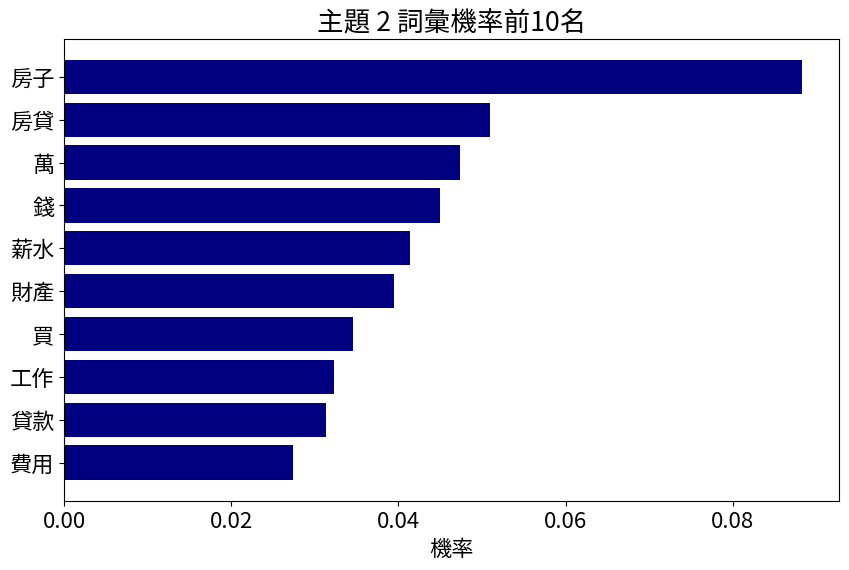

In [ ]:
# 視覺化顯示主題-詞彙分佈
topic_n = 2
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

我們也列出了前十高的詞彙，從分布長條圖能看出，房子是提及最多的，其次是房貸，還有如萬、錢這類與金錢相關的用字，說明這個主題中討論最多的還是多圍繞在房產及金錢的劃分，可能可以反映出婚姻關係中與房屋相關的經濟負擔、收入財產分配的爭議是最常見的。

In [ ]:
from bertopic.representation import KeyBERTInspired
# KeyBERT
keybert = KeyBERTInspired()

# 設定HDBscan模型
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=30)

# 定義我們要用到的representation model
representation_model = {
    "KeyBERT": keybert,
}

In [ ]:
# 建立BERTopic模型
representation_topic_model = BERTopic(
  # Sub-models
  embedding_model=bert_sentence_model,
  vectorizer_model=jieba_vectorizer,
  # 設定Representation model
  representation_model=representation_model,
  # Hyperparameters
  top_n_words=30,
  verbose=True
)

# Train model
topics, probs = representation_topic_model.fit_transform(docs_zh, all_embeddings) 

2025-05-10 03:41:55,606 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 03:43:13,490 - BERTopic - Dimensionality - Completed ✓
2025-05-10 03:43:13,492 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 03:43:19,574 - BERTopic - Cluster - Completed ✓
2025-05-10 03:43:19,586 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-10 03:43:32,595 - BERTopic - Representation - Completed ✓


In [ ]:
# 觀察KeyBERT微調後的主題表示
representation_topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Representative_Docs
0,-1,78153,-1_說_小孩_妳_,"[說, 小孩, 妳, , 老婆, 想, 老公, 真的, 做, 工作, 離婚, 孩子, 生活...","[有沒有, 好好, 回家, 我媽, 房子, 希望, 開心, 婆家, 幫忙, 孩子]","[當她想吃東西時, 所以原又有回公婆家, 無意中從爸爸手機中的訊息內容發現跟一個女生聊天所以..."
1,0,1852,0_ ___,"[ , , , , , , , , , , , , , , , , , , , , , , ...","[, , , , , , , , , ]","[, , ]"
2,1,883,1_洗_衣服_地板_乾淨,"[洗, 衣服, 地板, 乾淨, 煮, 洗碗, 冰箱, 尿布, 浴室, 消毒, 空間, 洗碗機...","[洗碗機, 曬衣服, 洗衣機, 洗衣服, 晾衣服, 洗手, 拖地, 吸塵器, 機器人, 洗碗]","[我常常跟她說洗不乾淨, 現在兩人衣服也都我在洗, 只有洗自己的衣服]"
3,2,681,2_老婆_老公_岳父_你媽,"[老婆, 老公, 岳父, 你媽, 婆婆, 公婆, 喊停, 老爺, 不爽, 媳婦, 老馬, 喊...","[老姑婆, 你媽, 我愛我, 噴你媽, 老娘, 你家, 老公, 掛你, 玩不動, 老婆]","[他老婆不可以, 所以才處處覺得老婆的不是, 你老婆根本有問題]"
4,3,489,3_個性_脾氣_性格_很會,"[個性, 脾氣, 性格, 很會, 喜歡, 善良, 冷淡, 強勢, 溫和, 很強, 衛生習慣,...","[個性, 性格, 大男人主義, 好脾氣, 衛生習慣, 口頭禪, 和藹可親, 很強, 沒什麼,...","[這樣的個性, 對上這種個性的人, 同時她的個性也很好]"
...,...,...,...,...,...,...
658,657,10,657_迴圈_無窮_循環_無限,"[迴圈, 無窮, 循環, 無限, 沒學, 情況, 反感, 後援, 差異, 反正, , , ...","[迴圈, 無限, 無窮, 循環, 情況, 後援, 沒學, 反正, 差異, 反感]","[無限迴圈, 反正無窮迴圈, 無窮迴圈]"
659,658,10,658_偷不著_如來_偷_一把,"[偷不著, 如來, 偷, 一把, 拚, 有趣, 不給, 玩, 做, , , , , , ,...","[偷不著, 不給, 有趣, 偷, 一把, 拚, 玩, 如來, 做, ]","[不如拚一把, 不如來的有趣, 偷不如偷不著]"
660,659,10,659_做得還_盡善盡美_面面俱到_幅度,"[做得還, 盡善盡美, 面面俱到, 幅度, 自食其力, 有作, 太小, 到位, 承認, 終究...","[面面俱到, 盡善盡美, 做得還, 到位, 打算, 真的, 自食其力, 幅度, 我會, 算是]","[我自己很多地方有作到位, 我認為她進步幅度太小, 短期間內真的是很難做到盡善盡美]"
661,660,10,660_韓劇_電影_裡看_整部,"[韓劇, 電影, 裡看, 整部, 聽相聲, 聽陸劇, 過劇, 有累, 偶然, 動畫, 看劇,...","[聽陸劇, 看電視, 聽相聲, 小時候, 休息時間, 偶然, 抬頭, 天天, 看劇, 那天]","[而且兩次就把整部韓劇看完, 而且說實在的整天晾在家裡看韓劇休息, 我跟老公會一起看韓劇電影動畫]"


經過微調後，主題數量從原本的六個大幅增加到六百多個，顯示模型在嘗試更細緻地劃分，但可能原本文章的內容便差異不大，導致在過度細緻的劃分下，被迫分成許多小主題，雖然這可以捕捉到更多具體的婚姻議題，如家事分工、親子互動、娛樂活動等，但這種過度細化的結果可能反而不利於整體議題的統整。